In [2]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [11]:
DATA_PATH="./Vowel_Data/Vowel/"

def get_labels(path=DATA_PATH):
    labels=os.listdir(path)
    label_indices=np.arange(0,len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [12]:
def speech2mfcc(file_path,max_len=13):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    wave=wave[::2]
    mfcc=librosa.feature.mfcc(wave,sr=sr)
    if (max_len > mfcc.shape[1]): #.shape[1], 1-->column
        pad_width=max_len-mfcc.shape[1]
        mfcc=np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')
    else:
        mfcc=mfcc[:,:max_len]
    return mfcc

In [13]:
def save_data_to_array(path=DATA_PATH, max_len=13):
    labels,_,_=get_labels(path)

    for label in labels:
        mfcc_vectors=[]

        speechfiles=[path + label + '/' + speech for speech in os.listdir(path+'/'+label)]
        for speech in tqdm(speechfiles,"Saving vectors to label -'{}'".format(label)):
            mfcc=speech2mfcc(speech,max_len=max_len)
            mfcc_vectors.append(mfcc)
            
        np.save(label+'.npy',mfcc_vectors)

In [14]:
save_data_to_array()

Saving vectors to label -'vowel7': 100%|██████████| 40/40 [00:03<00:00, 10.11it/s]


In [15]:
seed=0
np.random.seed(seed)

In [16]:
labels,indices,_=get_labels(DATA_PATH)
X=np.load(labels[0]+'.npy')
y=np.zeros(X.shape[0])

for i,label in enumerate(labels[1:]):
    x=np.load(label+'.npy')
    X=np.vstack((X,x))
    y=np.append(y,np.full(x.shape[0],fill_value=(i+1)))
assert X.shape[0] == len(y)

X=X.reshape(X.shape[0],20,13,1)

In [17]:
kfold=StratifiedKFold(n_splits=4,shuffle=True,random_state=seed)
cv_score=[]

for train,test in kfold.split(X,y):
    np.random.seed(seed)
    Y=to_categorical(y)
    
    model=Sequential()
    model.add(Conv2D(64,kernel_size=(2,2),activation='tanh',input_shape=(20,13,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7,activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
    model.fit(X[train],Y[train],epochs=20,batch_size=10,verbose=0)
    
    scores=model.evaluate(X[test],Y[test],verbose=0)
    
    print("%s: %.2f%%" % (model.metrics_names[1],scores[1]*100))
    
    cv_score.append(scores[1]*100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_score),np.std(cv_score)))

acc: 95.71%
acc: 94.29%
acc: 92.86%
acc: 92.86%
93.93% (+/- 1.18%)


In [121]:
Word:
acc: 90.00%
acc: 87.14%
acc: 90.00%
acc: 92.86%
90.00% (+/- 2.02%)

In [ ]:
Vowel:
acc: 95.71%
acc: 94.29%
acc: 92.86%
acc: 92.86%
93.93% (+/- 1.18%)

In [79]:
history_dict=history.history
final_loss=history_dict['loss'][-1]
final_acc=history_dict['acc'][-1]

In [80]:
final_acc

0.8714285731315613

In [81]:
np.save('./Result/Training_trial7.npy',[final_loss, final_acc])

In [20]:
history_dict=history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)

In [59]:
np.load('./Result/Training_trial5.npy')

array([0.17341404, 0.93333334])

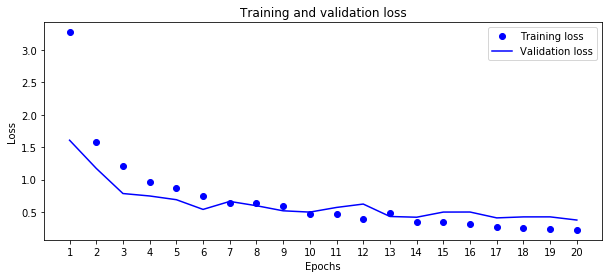

In [12]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_values,'bo',label='Training loss')
plt.plot(epochs,val_loss_values,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()
plt.savefig('loss_20_epochs.svg',format='svg', dpi=1200)

In [13]:
plt.clf()
acc_values=history_dict['acc']
val_acc_values=history_dict['val_acc']

<Figure size 432x288 with 0 Axes>

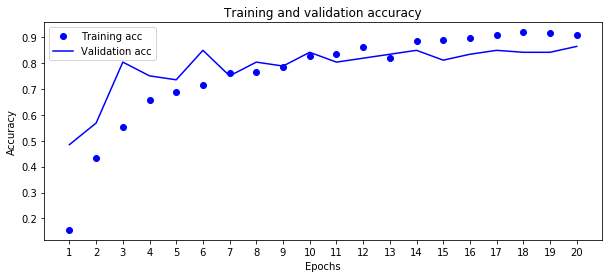

In [14]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_values,'bo',label='Training acc')
plt.plot(epochs,val_acc_values,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.show()
plt.savefig('accuracy_20_epochs.svg',format='svg', dpi=1200)

In [205]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 19, 10, 64)        320       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 9, 5, 64)          0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 9, 5, 64)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 2880)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               368768    
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 10)                1290      
Total para